In [1]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, welch
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt

# === Parameters ===
input_folder = "Raw Input"    # <-- change this
output_folder = "Peakfinder Input"
psd_folder = "[0] PSD_plots"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(psd_folder, exist_ok=True)

# Butterworth filter settings (narrower band)
bp_lowcut = 1.0
bp_highcut = 120.0
notch_low = 40.0
notch_high = 55.0
notch_order = 1
order = 4

# Welch PSD settings
nperseg = 1024
noverlap = nperseg // 2

# --- Filter functions ---
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandstop(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a

def apply_filters(signal, fs):
    # Bandpass 5-60 Hz
    b_bp, a_bp = butter_bandpass(bp_lowcut, bp_highcut, fs, order)
    filtered = filtfilt(b_bp, a_bp, signal)
    # Notch 49-51 Hz
    b_notch, a_notch = butter_bandstop(notch_low, notch_high, fs, notch_order)
    filtered = filtfilt(b_notch, a_notch, filtered)
    # Smoothing (moving average, 5 ms window)
    window_size = max(1, int(fs * 0.005))
    filtered = uniform_filter1d(filtered, size=window_size)
    return filtered

# --- Helper function ---
def find_header_row(filepath):
    """Find row where 'MS' and 'ValueG' appear"""
    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            if "MS" in line and "ValueG" in line:
                return i
    return 0

# --- Process files ---
files = [f for f in os.listdir(input_folder) if f.lower().endswith(".csv")]
print(f"Found {len(files)} CSV files.")

# ...existing code...

# ...existing code...

for filename in files:
    filepath = os.path.join(input_folder, filename)
    print(f"\nProcessing {filepath} ...")

    # Load CSV, skip metadata
    header_row = find_header_row(filepath)
    df = pd.read_csv(filepath, skiprows=header_row)

    if "MS" not in df.columns or "ValueG" not in df.columns:
        print("⚠️ Missing 'MS' or 'ValueG'. Skipping.")
        continue

    # Extract time and signal
    time = df["MS"].values
    signal = df["ValueG"].values

    # Convert ms → s if needed
    if np.max(time) > 1000:
        time = time / 1000.0

    # Compute sampling frequency robustly
    dt_values = np.diff(time)
    dt_clean = dt_values[dt_values > 0]  # ignore resets
    dt = np.median(dt_clean)
    fs = 1.0 / dt
    print(f"  Sampling rate ≈ {fs:.2f} Hz")

    # --- Apply bandpass + notch filter + smoothing ---
    filtered_signal = apply_filters(signal, fs)
    df["ValueG"] = filtered_signal  # <-- Overwrite ValueG column

    # --- Save filtered CSV ---
    out_csv_path = os.path.join(output_folder, filename)
    df.to_csv(out_csv_path, index=False)
    print(f"  ✅ Saved filtered CSV: {out_csv_path}")

    # --- Compute Welch PSD for both raw and filtered ---
    f_raw, Pxx_raw = welch(signal, fs=fs, nperseg=nperseg, noverlap=noverlap, window='hann')
    f_filt, Pxx_filt = welch(filtered_signal, fs=fs, nperseg=nperseg, noverlap=noverlap, window='hann')

    # --- Plot PSD comparison ---
    plt.figure(figsize=(8,4))
    plt.semilogy(f_raw, Pxx_raw, label="Raw")
    plt.semilogy(f_filt, Pxx_filt, label="Filtered")
    plt.xlim([0, 150])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (V^2/Hz)")
    plt.legend()
    plt.tight_layout()

    # Save PSD plot
    base_name = os.path.splitext(filename)[0]
    psd_path = os.path.join(psd_folder, base_name + "_PSD.png")
    plt.savefig(psd_path)
    plt.close()
    print(f"  ✅ Saved PSD plot: {psd_path}")
# ...existing code...

  Sampling rate ≈ 500.00 Hz
  ✅ Saved filtered CSV: Peakfinder Input\Animal10_April16.CSV
  ✅ Saved PSD plot: [0] PSD_plots\Animal10_April16_PSD.png

Processing Raw Input\Animal10_June26.CSV ...
  Sampling rate ≈ 500.00 Hz
  ✅ Saved filtered CSV: Peakfinder Input\Animal10_June26.CSV
  ✅ Saved PSD plot: [0] PSD_plots\Animal10_June26_PSD.png

Processing Raw Input\Animal10_May20.CSV ...
  Sampling rate ≈ 500.00 Hz
  ✅ Saved filtered CSV: Peakfinder Input\Animal10_May20.CSV
  ✅ Saved PSD plot: [0] PSD_plots\Animal10_May20_PSD.png

Processing Raw Input\Animal15_April16.CSV ...
  Sampling rate ≈ 500.00 Hz
  ✅ Saved filtered CSV: Peakfinder Input\Animal15_April16.CSV
  ✅ Saved PSD plot: [0] PSD_plots\Animal15_April16_PSD.png

Processing Raw Input\Animal15_June26.CSV ...
  Sampling rate ≈ 500.00 Hz
  ✅ Saved filtered CSV: Peakfinder Input\Animal15_June26.CSV
  ✅ Saved PSD plot: [0] PSD_plots\Animal15_June26_PSD.png

Processing Raw Input\Animal15_May20.CSV ...
  Sampling rate ≈ 500.00 Hz
  ✅ Sa

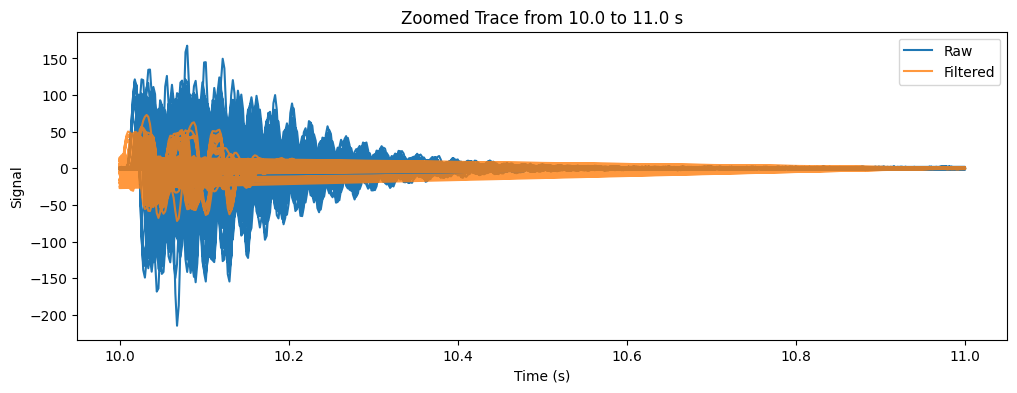

In [2]:
import matplotlib.pyplot as plt

# Define the time window
start_time = 10.0  # seconds
end_time = 11.0    # seconds

# Find indices corresponding to that window
indices = np.where((time >= start_time) & (time <= end_time))

plt.figure(figsize=(12,4))
plt.plot(time[indices], signal[indices], label="Raw")
plt.plot(time[indices], filtered_signal[indices], label="Filtered", alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title(f"Zoomed Trace from {start_time} to {end_time} s")
plt.legend()
plt.show()
